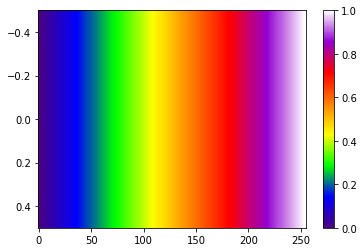

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pyvista as pv

# Définir les couleurs du bas au haut de la colormap de l'image
colors = [
    (75/255, 0, 130/255),   # indigo
    (0, 0, 255/255),        # bleu
    (0, 255/255, 0),        # vert
    (255/255, 255/255, 0),  # jaune
    (255/255, 127/255, 0),  # orange
    (255/255, 0 , 0),        # rouge
    (148/255, 0, 211/255),  # violet
    (1, 1, 1)               # blanc

]

cmap_name = 'custom_gradient'

# Créer la colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


# Afficher la colormap dans Matplotlib
plt.imshow(np.linspace(0, 1, 256)[None, :], aspect='auto', cmap=custom_cmap)
plt.colorbar()
plt.show()


In [2]:
import os
import feelpp
from feelpp.toolboxes.cfpdes import *
from tools.lap2D_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain

class Poisson:
  """
  Solves the problem
  -Laplacian u = f   in Omega
  u            = g   in boundary
  
  - with f,g are set by the user
  """
  def __init__(self, dim=2, order=1):

    self.dim   = dim
    self.model = dict()
    self.order = order
  
  def genCube(self, filename, h=0.1):
    """
    Generate a cube geometry following the dimension  self.dim
    """

    
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(h, self.dim)
    
    if self.dim==2 :
        geo+="""
        Rectangle(1) = {0, 0, 0, 1, 1, 0};
        Characteristic Length{ PointsOf{ Surface{1}; } } = h;
        Physical Curve("Gamma_D") = {1,2,3,4};
        Physical Surface("Omega") = {1};
        """
    elif self.dim==3 :
        geo+="""
        Box(1) = {0, 0, 0, 1, 1, 1};
        Characteristic Length{ PointsOf{ Volume{1}; } } = h;
        Physical Surface("Gamma_D") = {1,2,3,4,5,6};
        Physical Volume("Omega") = {1};
        """
    with open(filename, 'w') as f:
        f.write(geo)

  
  
  def __call__(self,
               h,                                       # mesh size 
               order=1,                                 # polynomial order 
               name='Potential',                        # name of the variable u
               rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)',   # right hand side
               diff='{1,0,0,1}',                        # diffusion matrix
               g='0',
               geofile=None,
               plot=None,
               solver='feelpp'):
    """
    Solves the problem where :
    - h is the mesh size
    - order the polynomial order
    - rhs is the expression of the right-hand side f(x,y)
    """
    self.pb    = cfpdes(dim=self.dim, keyword=f"cfpdes-{self.dim}d-p{self.order}")
    self.model = {
      "Name": "Laplacian",
      "ShortName": "Laplacian",
      "Models":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "equations":"poisson_eq"
        },
        "poisson_eq":{
          "setup":{
            "unknown":{
              "basis":f"Pch{order}",
              "name":f"{name}",
              "symbol":"u"
            },
            "coefficients":{
              "c": f"{diff}:x:y" if self.dim == 2 else f"{diff}:x:y:z",
              "f": f"{rhs}:x:y"  if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      },
      "Materials":
      {
        "Omega":
        {
          "markers":["Omega"]
        }
      },
      "BoundaryConditions":
      {
        "poisson_eq":
        {
          "Dirichlet":
          {
            "g":
            {
              "markers":["Gamma_D"],
              "expr":f"{g}:x:y"
            }
          }
        }
      },
      "PostProcess":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "Exports":
          {
            "fields":["all"],
            "expr":{
              "rhs"    : f"{rhs}:x:y" if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      }
    }

    fn = None
    if geofile is None:
      fn = f'omega-{self.dim}.geo'
      self.genCube(fn, h)
    else:
      fn = geofile
    
        
##________________________

    if solver == 'feelpp':
      print(f"Solving the laplacian problem for hsize = {h}...")
      feelpp_mesh = feelpp.load(feelpp.mesh(dim=self.dim, realdim=self.dim), fn, h)
      self.pb.setMesh(feelpp_mesh)
      self.pb.setModelProperties(self.model)
      self.pb.init(buildModelAlgebraicFactory=True)
      self.pb.printAndSaveInfo()
      self.pb.solve()
      self.pb.exportResults()
      #measures = self.pb.postProcessMeasures().values()
      """
      try:
        import pandas as pd
        df=pd.DataFrame([measures])
        print(df)
      except ImportError:
        print("cannot import pandas, no problem it was just a test")
    """
##______________________
      #mesh = self.pb.mesh()
      #function_space = self.pb.functionSpace()
      #dofs = function_space.dofs()
##________________________
      #return mesh, dofs
##________________________

    elif solver == 'scimba':
      print("Solving using Scimba")
      # Define a disk domain
      if geofile == 'geo/disk.geo' :
        xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, center=[0.0, 0.0], radius=1.0))
        pde_disk = PoissonDisk2D(xdomain,  rhs= rhs, g= g)
        Run_laplacian2D(pde_disk)

      # Define a square domain
      elif geofile == None:
        xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
        pde = Poisson_2D(xdomain,  rhs= rhs, g= g)
        Run_laplacian2D(pde)
##________________________

    # Plots
    if plot != None:
      
      from xvfbwrapper import Xvfb
      import pyvista as pv 
      import matplotlib.pyplot as plt


      #vdisplay = Xvfb()
      #vdisplay.start()
      pv.set_jupyter_backend('static') 
      pv.start_xvfb()

      mesh = pv.get_reader(f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case").read()
      
      pl = pv.Plotter(shape=(1,2))
      pl.add_title(f'Solution P{order}', font_size=18)
      pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson_eq.{name}", cmap=custom_cmap)
      pl.subplot(0,1)
      pl.add_title('f=' + rhs, font_size=18)
      pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.rhs', cmap=custom_cmap)
      pl.link_views()

      if self.dim ==3:
        pl.view_isometric()
      else:
        pl.view_xy()  # if mesh_2D is on the xy plane.        
      
      pl.show()
      pl.screenshot(plot)

    


Using device: cpu
torch loaded; device is cpu


In [3]:
import sys
import feelpp
import feelpp.toolboxes.core as tb

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-May-22
 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs


Solving the laplacian problem for hsize = 0.08...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.08 
+--------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                           |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                         |
| | Environment                                                                          |                                  

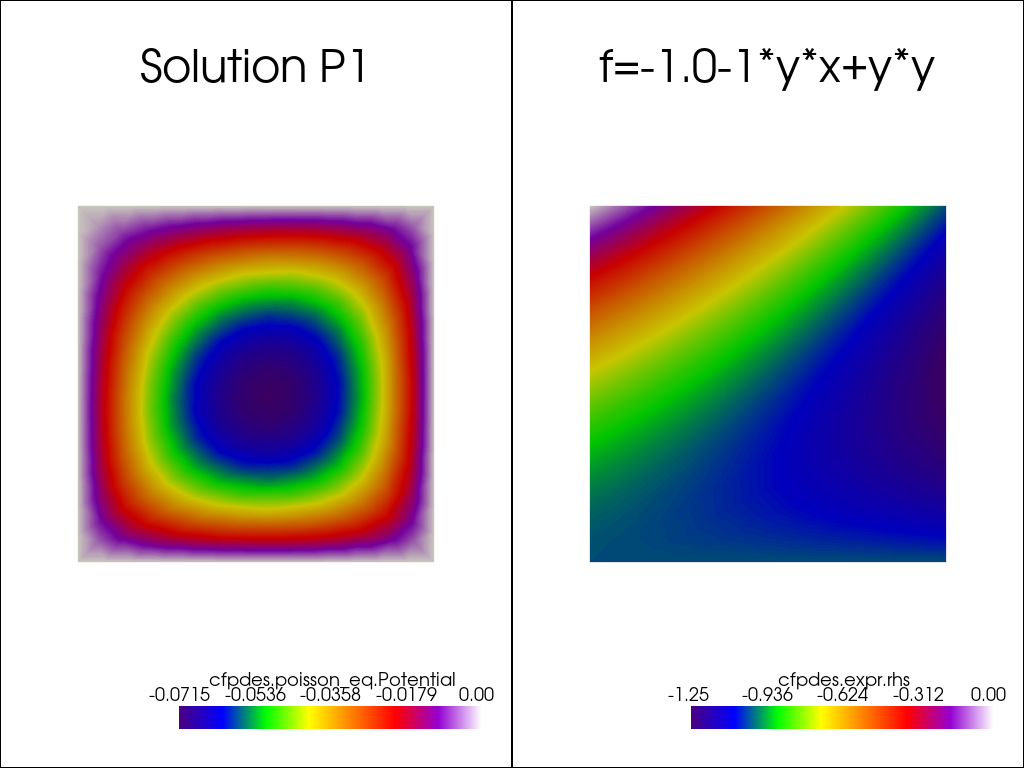

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.16e+00
epoch     0: best loss = 1.16e+00
epoch     1: best loss = 7.33e-01
epoch     2: best loss = 3.70e-01
epoch     3: best loss = 1.27e-01
epoch     7: best loss = 1.27e-01
epoch     8: best loss = 8.85e-02
epoch    19: best loss = 8.03e-02
epoch    20: best loss = 7.69e-02
epoch    25: best loss = 7.59e-02
epoch    31: best loss = 7.53e-02
epoch    32: best loss = 7.18e-02
epoch    36: best loss = 7.18e-02
epoch    37: best loss = 6.79e-02
epoch    40: best loss = 6.73e-02
epoch    42: best loss = 6.62e-02
epoch    43: best loss = 6.58e-02
epoch    44: best loss = 6.44e-02
epoch    46: best loss = 6.09e-02
epoch    51: best loss = 5.89e-02
epoch    54: best loss = 5.68e-02
epoch    55: best loss = 5.66e-02
epoch    56: best loss = 5.56e-02
epoch    57: best loss = 5.55e-02
epoch    58: be

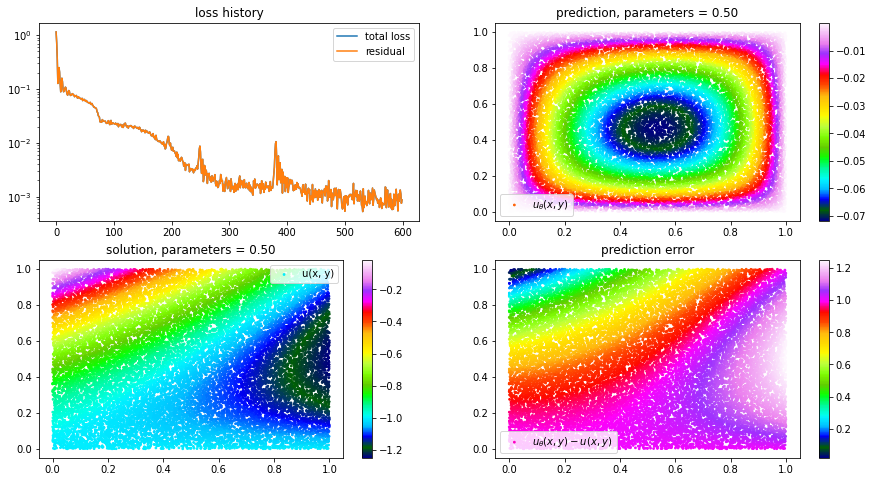

In [4]:
P = Poisson(dim = 2)
P(h=0.08,  rhs='-1.0-1*y*x+y*y', g='0', order=1, plot='f4.png')
P(h=0.08,  rhs='-1.0-1*y*x+y*y', g='0', order=1, solver='scimba')

Solving the laplacian problem for hsize = 0.08...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/geo/disk.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/geo/disk.geo 0.08 
+--------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                           |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                         |
| | Environment                                                                          |                                                         |
| +------------------------

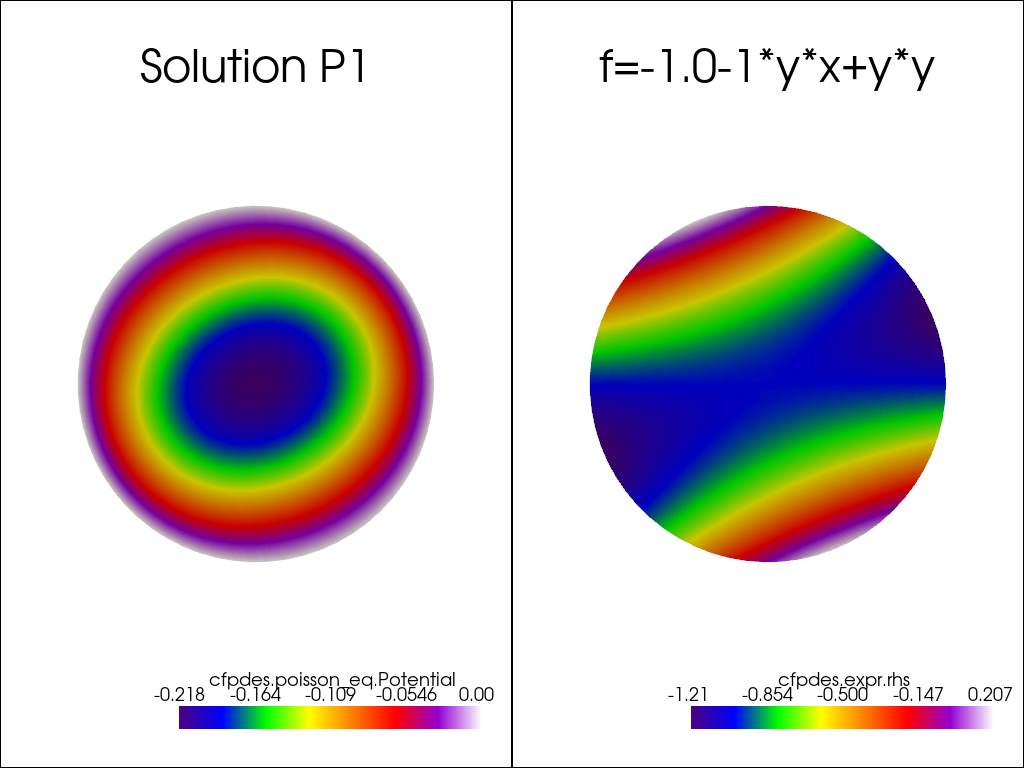

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 6.67e-01
epoch     0: best loss = 6.67e-01
epoch     1: best loss = 6.40e-01
epoch     2: best loss = 5.76e-01
epoch     3: best loss = 4.69e-01
epoch     4: best loss = 3.23e-01
epoch     5: best loss = 1.86e-01
epoch     6: best loss = 1.46e-01
epoch     9: best loss = 1.45e-01
epoch    10: best loss = 1.37e-01
epoch    13: best loss = 1.30e-01
epoch    14: best loss = 1.16e-01
epoch    15: best loss = 9.40e-02
epoch    16: best loss = 7.73e-02
epoch    17: best loss = 6.93e-02
epoch    19: best loss = 6.89e-02
epoch    20: best loss = 5.13e-02
epoch    21: best loss = 4.40e-02
epoch    22: best loss = 3.28e-02
epoch    23: best loss = 3.14e-02
epoch    26: best loss = 3.02e-02
epoch    28: best loss = 2.53e-02
epoch    29: best loss = 1.84e-02
epoch    32: best loss = 1.64e-02
epoch    36: be

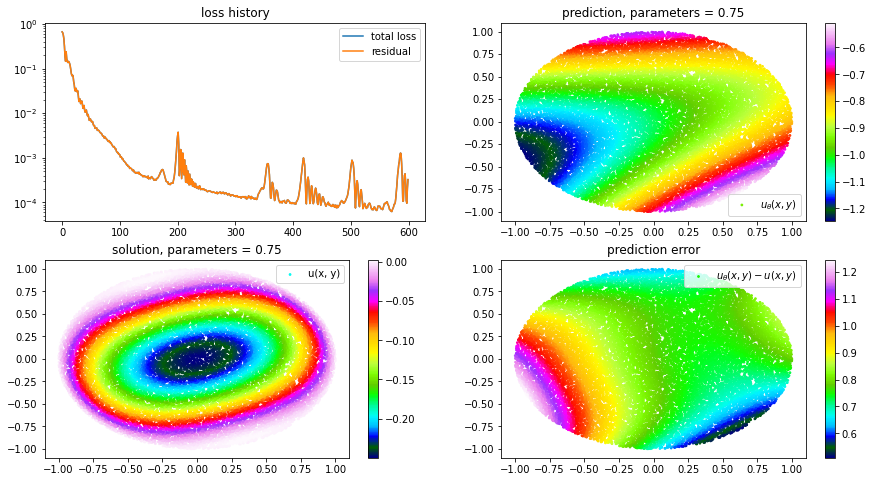

Solving the laplacian problem for hsize = 0.1...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+----------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                           |
| | Environment                                                                          |                            

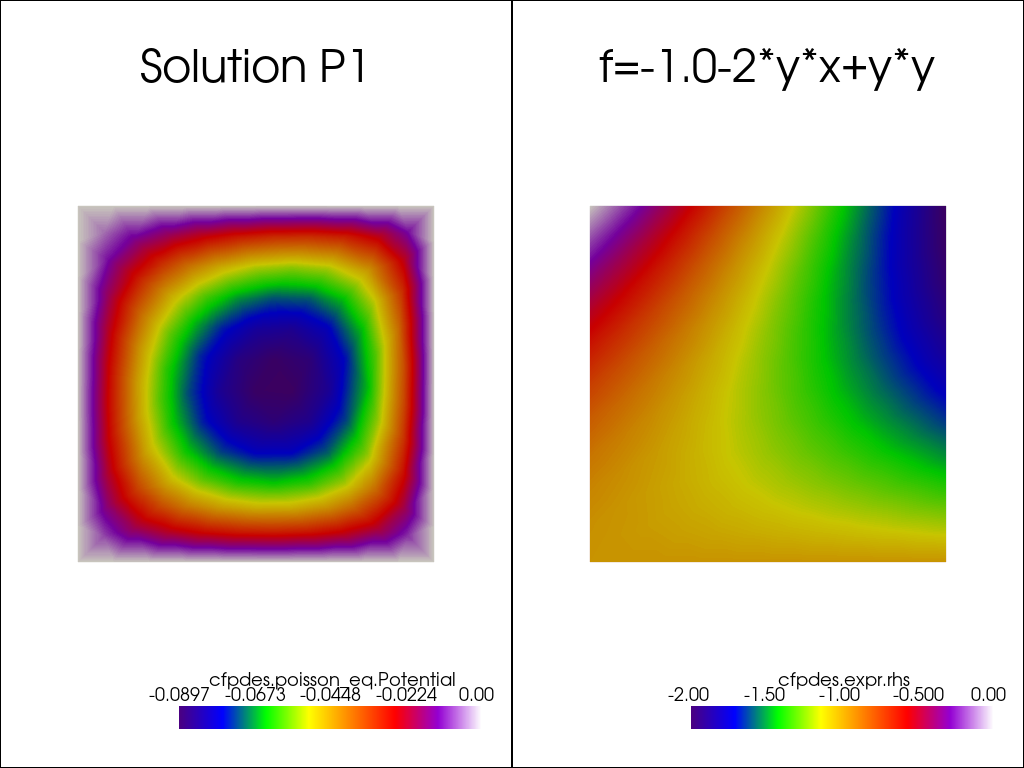

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.36e+00
epoch     0: best loss = 1.36e+00
epoch     1: best loss = 8.50e-01
epoch     2: best loss = 4.18e-01
epoch     3: best loss = 1.96e-01
epoch     8: best loss = 1.90e-01
epoch    14: best loss = 1.89e-01
epoch    20: best loss = 1.89e-01
epoch    21: best loss = 1.84e-01
epoch    22: best loss = 1.79e-01
epoch    29: best loss = 1.75e-01
epoch    34: best loss = 1.70e-01
epoch    35: best loss = 1.67e-01
epoch    37: best loss = 1.66e-01
epoch    39: best loss = 1.52e-01
epoch    46: best loss = 1.49e-01
epoch    48: best loss = 1.42e-01
epoch    54: best loss = 1.34e-01
epoch    58: best loss = 1.25e-01
epoch    59: best loss = 1.23e-01
epoch    64: best loss = 1.15e-01
epoch    67: best loss = 1.14e-01
epoch    68: best loss = 1.05e-01
epoch    69: best loss = 1.01e-01
epoch    70: be

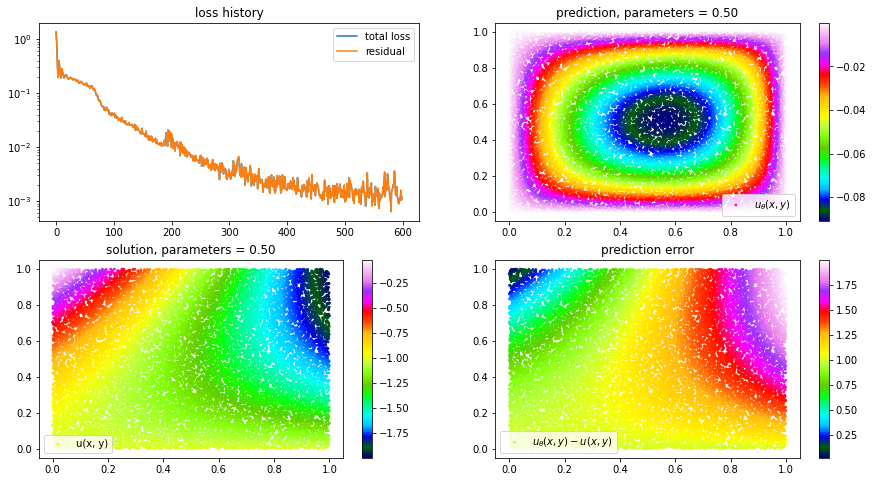

In [5]:


# 2D with varying RHS
P = Poisson(dim = 2)
P(h=0.08,  rhs='-1.0-1*y*x+y*y', g='0', order=1, geofile='geo/disk.geo', plot='2d.png')
P(h=0.08,  rhs='-1.0-1*y*x+y*y', g='0', order=1, geofile='geo/disk.geo', solver='scimba')


P(h=0.1,  rhs='-1.0-2*y*x+y*y', g='0', order=1, plot='f2.png')
P(h=0.1,  rhs='-1.0-2*y*x+y*y', g='0', order=1, solver ='scimba')



Solving the laplacian problem for hsize = 0.1...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+----------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                           |
| | Environment                                                                          |                            

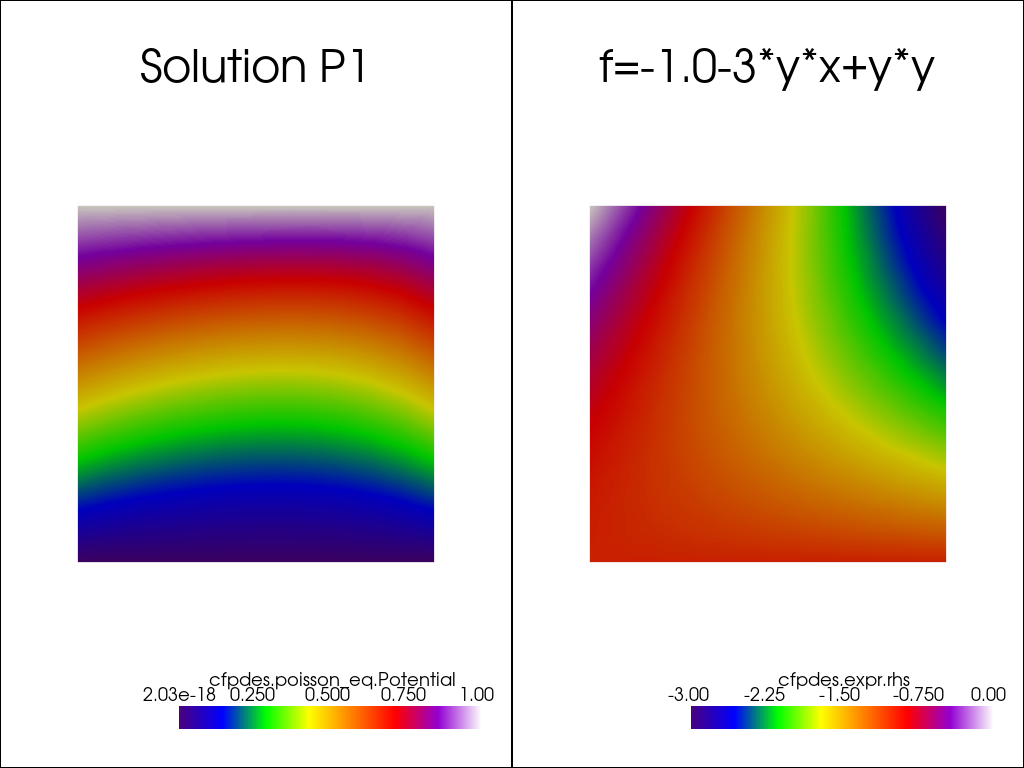

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 2.04e+00
epoch     0: best loss = 2.04e+00
epoch     1: best loss = 1.61e+00
epoch     2: best loss = 1.18e+00
epoch     3: best loss = 7.46e-01
epoch     4: best loss = 4.02e-01
epoch    16: best loss = 3.88e-01
epoch    19: best loss = 3.84e-01
epoch    21: best loss = 3.71e-01
epoch    22: best loss = 3.55e-01
epoch    24: best loss = 3.51e-01
epoch    25: best loss = 3.36e-01
epoch    26: best loss = 3.29e-01
epoch    29: best loss = 2.97e-01
epoch    30: best loss = 2.78e-01
epoch    32: best loss = 2.55e-01
epoch    35: best loss = 2.39e-01
epoch    36: best loss = 2.16e-01
epoch    37: best loss = 2.12e-01
epoch    39: best loss = 1.95e-01
epoch    40: best loss = 1.75e-01
epoch    41: best loss = 1.68e-01
epoch    42: best loss = 1.62e-01
epoch    43: best loss = 1.46e-01
epoch    44: be

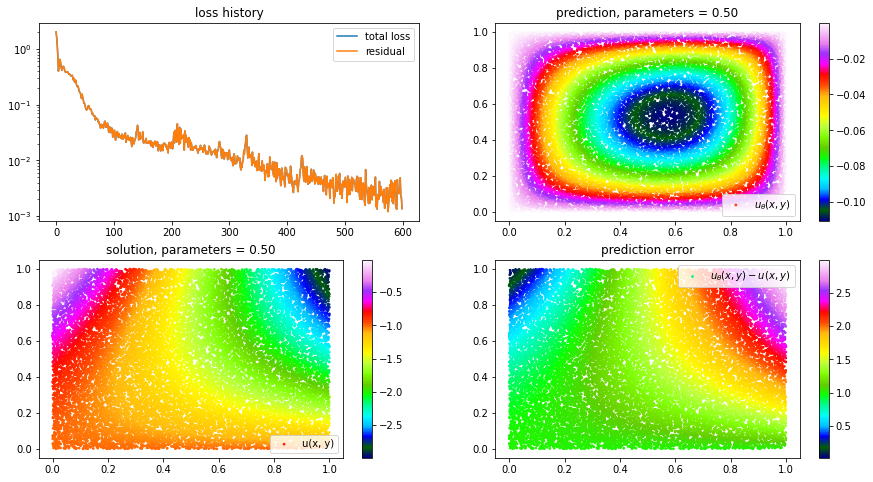

Solving the laplacian problem for hsize = 0.1...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+----------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                           |
| | Environment                                                                          |                            

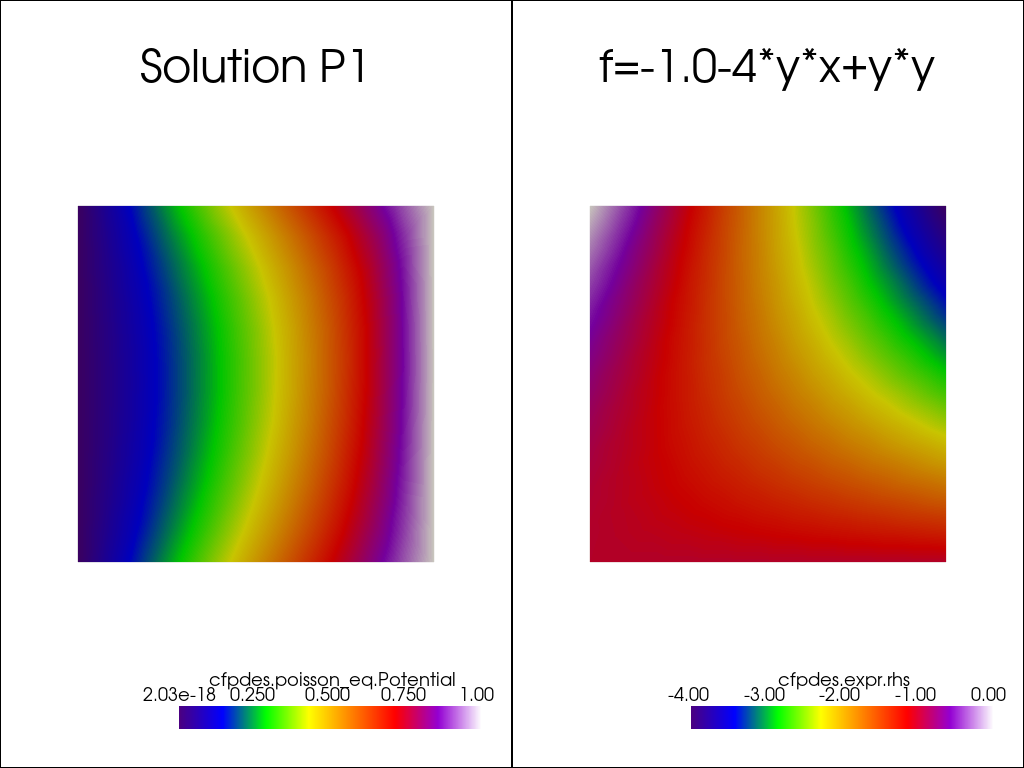

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 3.00e+00
epoch     0: best loss = 3.00e+00
epoch     1: best loss = 2.33e+00
epoch     2: best loss = 1.81e+00
epoch     3: best loss = 1.19e+00
epoch     4: best loss = 7.88e-01
epoch    10: best loss = 6.93e-01
epoch    11: best loss = 6.63e-01
epoch    18: best loss = 6.12e-01
epoch    20: best loss = 5.70e-01
epoch    22: best loss = 5.32e-01
epoch    23: best loss = 4.98e-01
epoch    25: best loss = 4.80e-01
epoch    26: best loss = 4.39e-01
epoch    27: best loss = 3.83e-01
epoch    28: best loss = 3.56e-01
epoch    29: best loss = 3.07e-01
epoch    30: best loss = 2.97e-01
epoch    31: best loss = 2.52e-01
epoch    32: best loss = 2.41e-01
epoch    35: best loss = 2.19e-01
epoch    36: best loss = 2.16e-01
epoch    37: best loss = 2.09e-01
epoch    38: best loss = 1.92e-01
epoch    39: be

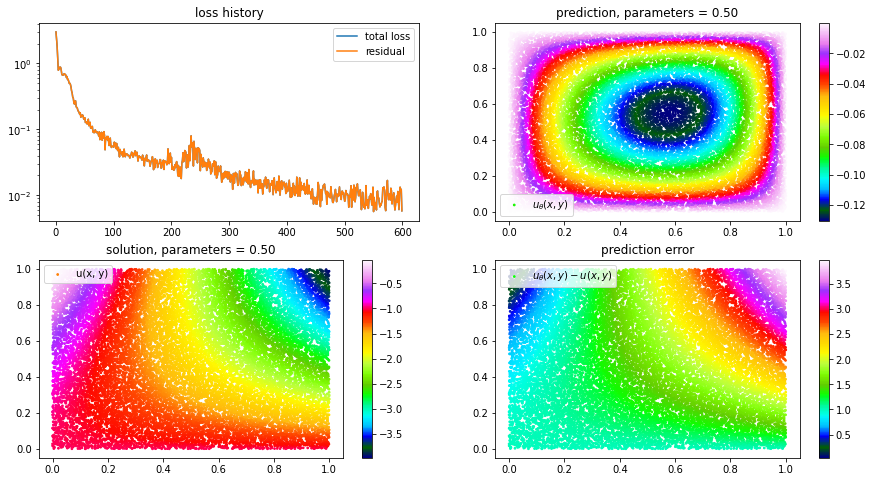

Solving the laplacian problem for hsize = 0.05...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                         |
+------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                       |
| | Environment                                                                          |                                          

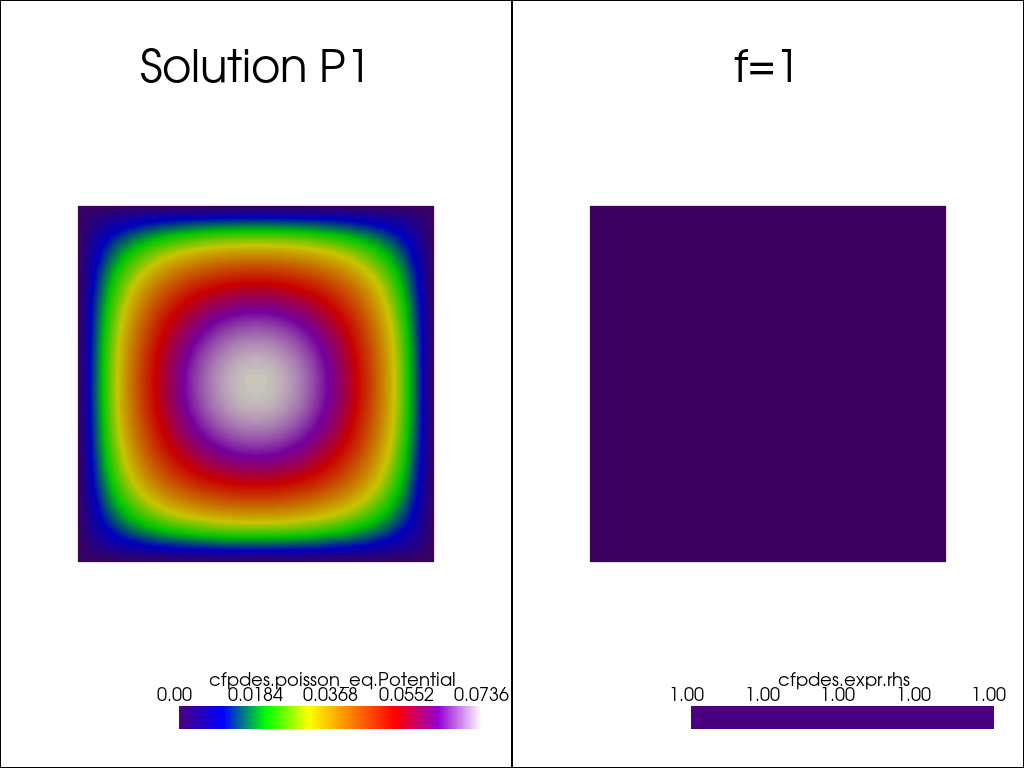

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 6.40e-01
epoch     0: best loss = 6.40e-01
epoch     1: best loss = 4.31e-01
epoch     2: best loss = 2.33e-01
epoch     3: best loss = 1.05e-01
epoch     7: best loss = 9.61e-02
epoch    12: best loss = 8.92e-02
epoch    18: best loss = 8.74e-02
epoch    59: best loss = 8.74e-02
epoch    65: best loss = 8.60e-02
epoch    74: best loss = 8.58e-02
epoch    75: best loss = 8.24e-02
epoch    77: best loss = 8.23e-02
epoch    79: best loss = 8.02e-02
epoch    80: best loss = 7.75e-02
epoch    82: best loss = 7.72e-02
epoch    83: best loss = 7.41e-02
epoch    84: best loss = 6.95e-02
epoch    85: best loss = 6.61e-02
epoch    86: best loss = 5.75e-02
epoch    87: best loss = 4.63e-02
epoch    88: best loss = 3.87e-02
epoch    89: best loss = 3.73e-02
epoch    93: best loss = 3.53e-02
epoch    96: be

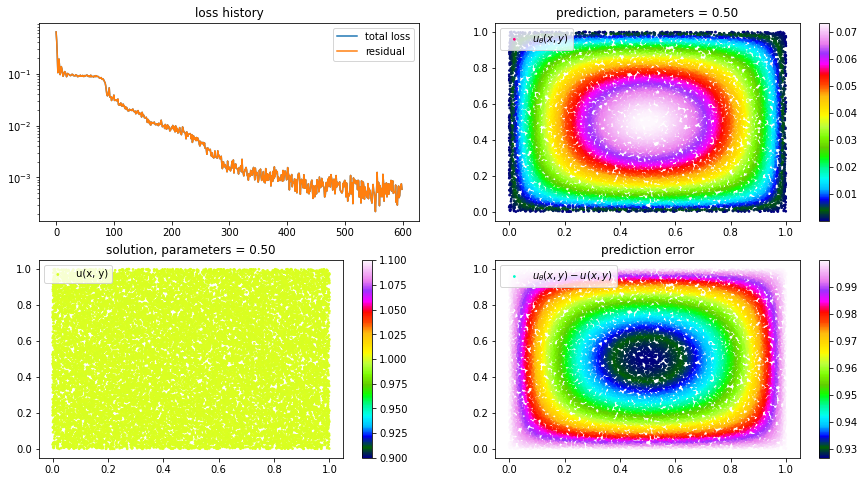

In [6]:


P(h=0.1,  rhs='-1.0-3*y*x+y*y', g='y', order=1, plot='f3.png')
P(h=0.1,  rhs='-1.0-3*y*x+y*y', g='y', order=1, solver ='scimba')


P(h=0.1,  rhs='-1.0-4*y*x+y*y', g='x', order=1, plot='f4.png')
P(h=0.1,  rhs='-1.0-4*y*x+y*y', g='x', order=1, solver ='scimba')

P(h=0.05, rhs='1',              g='0', order=1, plot='f5.png')
P(h=0.05, rhs='1 + x-x',              g='0', order=1, solver ='scimba')



Solving the laplacian problem for hsize = 0.1...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+---------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                          |
| | Environment                                                                          |                                

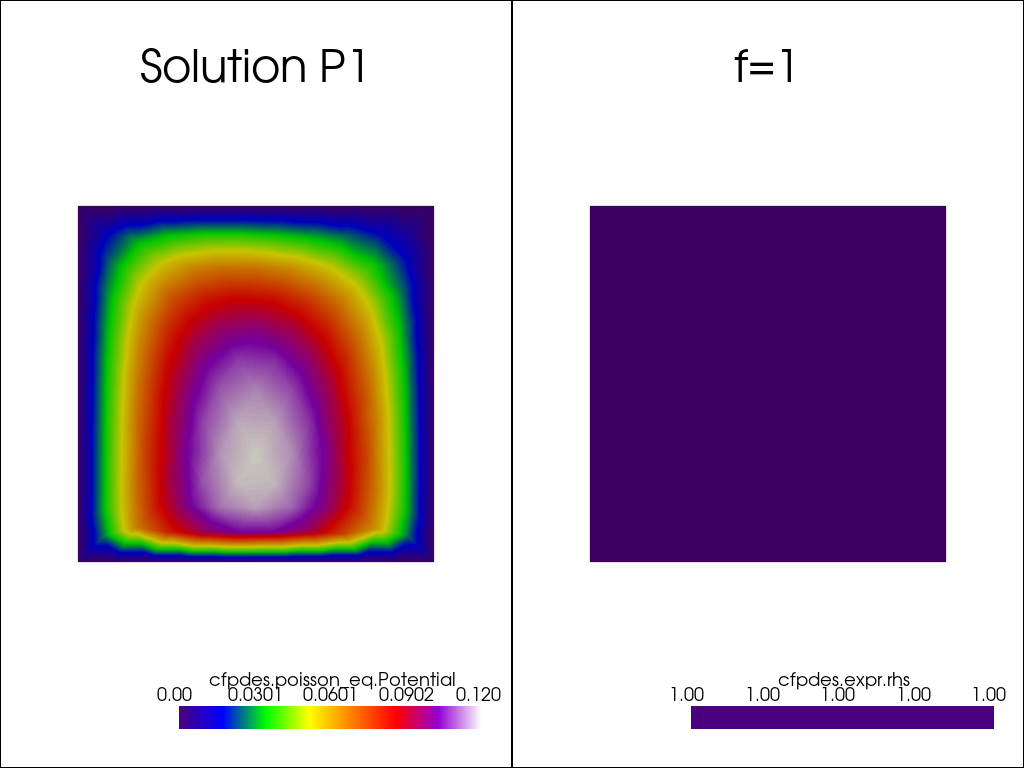

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.03e+00
epoch     0: best loss = 1.03e+00
epoch     1: best loss = 7.19e-01
epoch     2: best loss = 4.56e-01
epoch     3: best loss = 2.25e-01
epoch     4: best loss = 1.03e-01
epoch     9: best loss = 9.54e-02
epoch    10: best loss = 9.16e-02
epoch    17: best loss = 9.05e-02
epoch    25: best loss = 9.02e-02
epoch    30: best loss = 8.76e-02
epoch    39: best loss = 8.76e-02
epoch    42: best loss = 8.75e-02
epoch    45: best loss = 8.61e-02
epoch    51: best loss = 8.35e-02
epoch    53: best loss = 8.30e-02
epoch    54: best loss = 8.22e-02
epoch    56: best loss = 7.97e-02
epoch    57: best loss = 7.52e-02
epoch    59: best loss = 7.18e-02
epoch    60: best loss = 6.85e-02
epoch    61: best loss = 6.78e-02
epoch    62: best loss = 6.38e-02
epoch    63: best loss = 6.30e-02
epoch    66: be

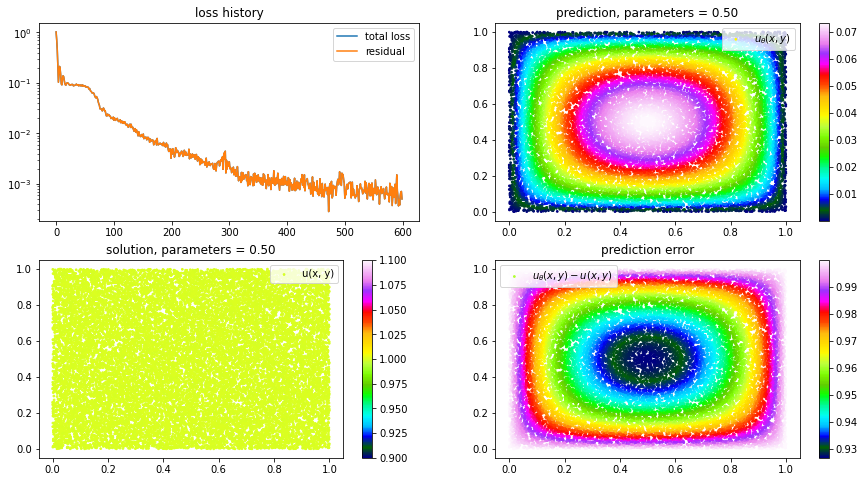

Solving the laplacian problem for hsize = 0.1...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+--------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                           |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                         |
| | Environment                                                                          |                                    

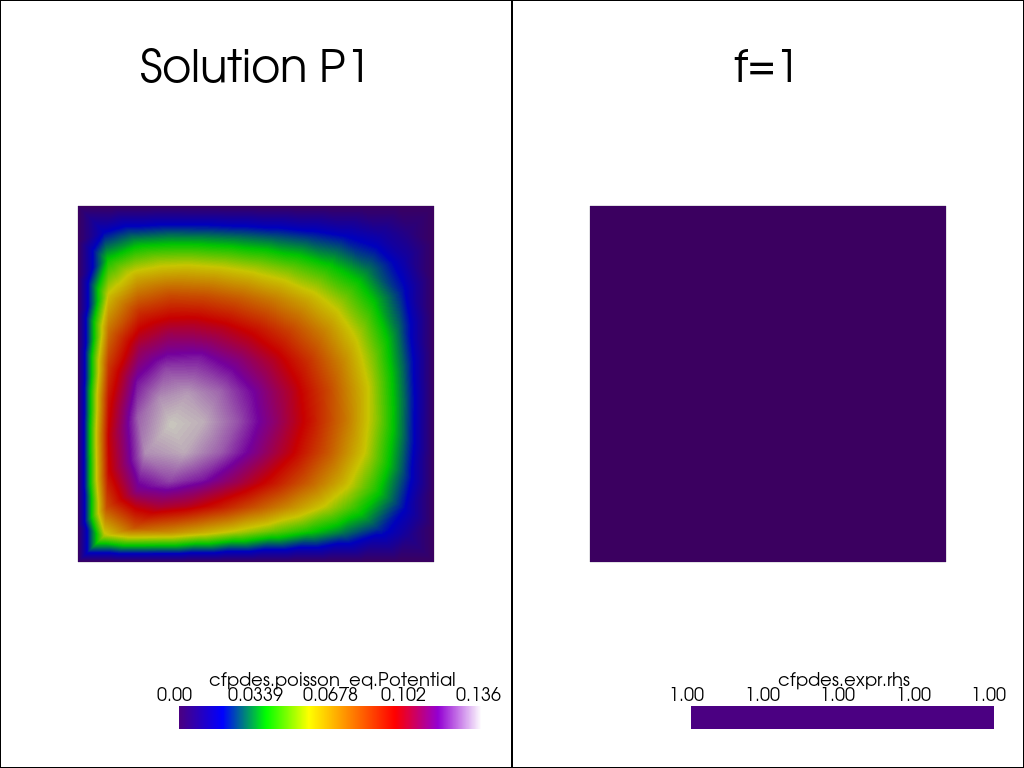

Solving using Scimba
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.33e+00
epoch     0: best loss = 1.33e+00
epoch     1: best loss = 1.04e+00
epoch     2: best loss = 7.73e-01
epoch     3: best loss = 4.79e-01
epoch     4: best loss = 2.06e-01
epoch     5: best loss = 9.56e-02
epoch    10: best loss = 8.96e-02
epoch    41: best loss = 8.86e-02
epoch    50: best loss = 8.85e-02
epoch    51: best loss = 8.73e-02
epoch    56: best loss = 8.72e-02
epoch    57: best loss = 8.41e-02
epoch    58: best loss = 8.38e-02
epoch    61: best loss = 8.19e-02
epoch    62: best loss = 7.99e-02
epoch    63: best loss = 7.68e-02
epoch    64: best loss = 7.19e-02
epoch    65: best loss = 7.15e-02
epoch    66: best loss = 6.38e-02
epoch    67: best loss = 6.18e-02
epoch    68: best loss = 5.99e-02
epoch    69: best loss = 5.72e-02
epoch    73: best loss = 5.65e-02
epoch    74: be

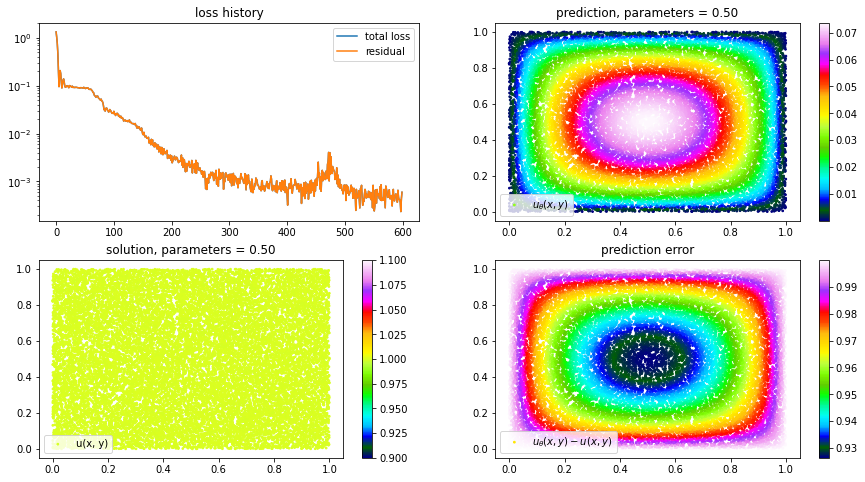

In [7]:


# # 2D with varying anisotropy
#P = Poisson(dim = 2)
P(h=0.1, diff='{1.0,0,0,x*y}', rhs='1', plot='d1.png')
P(h=0.1, diff='(1+x,0,0,1+y)', rhs='1+ x-x', solver='scimba')

P(h=0.1, diff='{x,y,-y,x+y}',  rhs='1', plot='d3.png')
P(h=0.1, diff='(x,y,-y,x+y)',  rhs='1+ x-x', solver='scimba')



Solving the laplacian problem for hsize = 0.08...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/geo/cube.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/geo/cube.geo 0.08 
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-3d-p1 - Use Case Study                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                                      |
| | Environment                                                                          |                                  

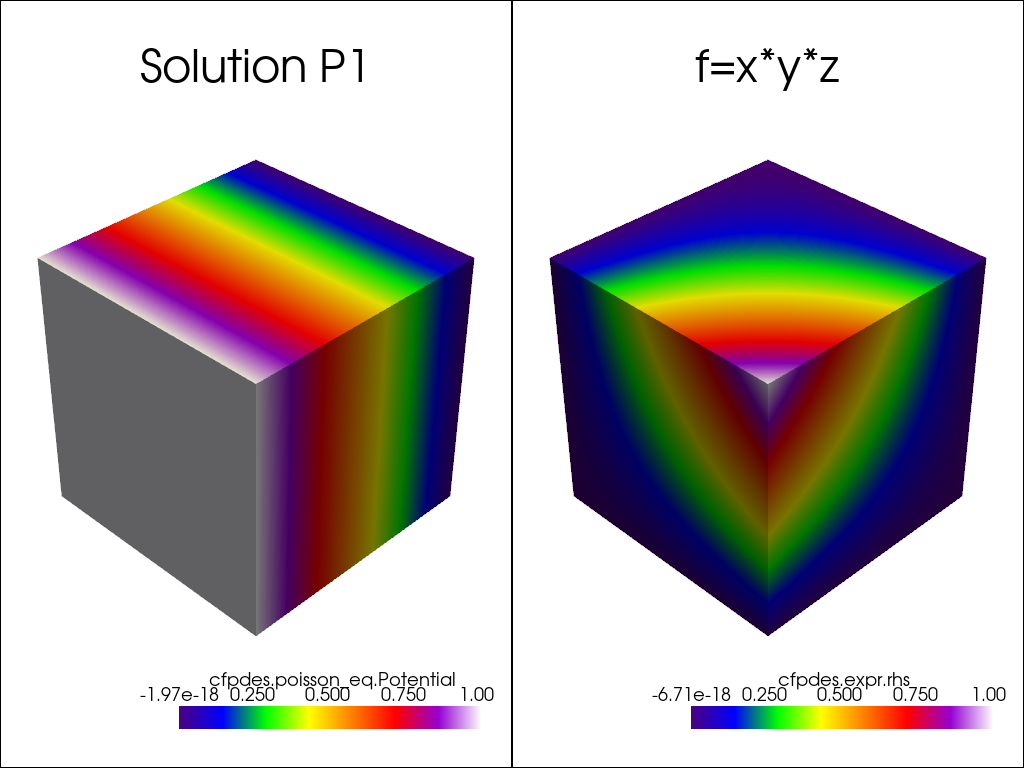

In [8]:


# 3D with varying anisotropy and non-homogeneous Dirichlet BC
P = Poisson(dim = 3)
P(h=0.08, diff='{1,0,0,0,x+1,0,0,0,1+x*y}', g = 'x', rhs='x*y*z', geofile = 'geo/cube.geo', plot='3d.png')
